In [21]:
%matplotlib widget
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np

plt.close("all")

# Create an Opti instance
opti = ca.Opti()

# Solver options
p_opts = {
    "expand":True,
    #"qpsol": "ipopt",
    #"convexify_strategy": "regularize",
    "print_time": 0,
    #"print_iteration": 0,
    #"print_header": 0,
    "verbose": False,
    "error_on_fail": False
}
s_opts = {}
opti.solver("ipopt",p_opts,
                    s_opts)



#=========== Parameters of the static models
B1_power = np.array([[2.8481E-02,0,0],[0,3.3614E-02,0],[0,0,1.7562E-02]])
B2_power = np.array([[1.6230E-05,0,0],[0,5.1395E-05,0],[0,0,2.7402E-05]])
C_power = np.array([[7.4287E-02],[1.0755E+00],[7.6364E-02]])


B1_pressure = np.array([9.2727E-05])
B2_pressure = np.array([2.5979E-08])
C_pressure = np.array([5.3955E-01])

zs = 3;

#=========== Parameters of the ARX model
# array of params
A_outflow = np.array([-1.2312E-03,1.5751E-02,1.4445E-03,-1.4182E-02,1.7257E-03,-1.5083E-02,1.3046E-01,-9.8236E-04,1.8656E-02,1.9622E-02]).reshape((1,-1))

#=========== Desired value of y 
Qout_meas = opti.parameter(zs)   # ascending index: older data, at 0: last measured value (t-1)
Qin_est = opti.parameter()
w_meas =  opti.parameter(3,zs)   #TODO: Remove hard-coded Dims
# w_meas =  opti.parameter(zs)   #TODO: Remove hard-coded Dims

h_meas = opti.parameter(zs)
E_meas = opti.parameter(zs)
P_meas = opti.parameter(zs)

#=========== Define the Horizon
N = 12 # 2min
Ts = 10  

#=========== Declare Symbolic Variables (SISO but can be extended to MIMO or MISO)
Qout = opti.variable(N+zs)
Qin = opti.variable(N+zs)
E = opti.variable(3,N+zs)
P = opti.variable(N+zs)
w = opti.variable(3,N+zs)
# w = opti.variable(N+zs)
h = opti.variable(N+zs)

#============= Slack Variables
s_h = opti.variable(N+zs)
# s_p = opti.variable(N+zs)

Qin[:] = Qin_est


#=========== Objective function
# Minimize the deviation of y from yd and control effort
objective = 0
r = np.zeros(N+zs)
r[1:-1] = ca.sqrt(1500)
for t in range(zs, N+zs):
    # objective += 5*((E[0,t]+E[1,t]+E[2,t])/(Qout[t]+1))**2 + 0.5*(w[0,t]+w[1,t]+w[2,t])**2
    objective += 5*((E[:,t].T @ E[:,t])/(Qout[t]**2+1))**2+ 0.0001*((w[:,t].T)**2 @ w[:,t]**2)+ 10000000*s_h[t]
    # objective += 5*((E[:,t].T @ E[:,t])/(Qout[t]**2+1))**2# + 0.5*(w[0,t]+w[1,t]+w[2,t])**2
    # objective += 0.5*(h[t]-150)**2 + 0.1*w[:,t].T @ w[:,t]
    # objective += 0.5*(w[0,t]-r[t])**2    # Simple reference of w1
  

opti.minimize(objective)

    
A = 18

# ARX model constraints
for t in range(zs, N+zs):   
    opti.subject_to(Qout[t] == A_outflow @ ca.vcat([Qout[t-3],w[2,t-1]**2, w[2,t-1]*Qout[t-3], w[2,t-1]*w[0,t-1],Qout[t-3]**2, 
                                            w[2,t-1]*w[1,t-1], w[2,t-1], w[1,t-1]*w[0,t-1], w[1,t-1]**2, w[0,t-1]**2]))

    # opti.subject_to(Qout[t] == -1.2312E-03*Qout[t-3] + 1.5751E-02* w[2,t-1]**2 + 1.4445E-03 * w[2,t-1]*Qout[t-3] - 1.4182E-02 * w[2,t-1]*w[0,t-1] + 1.7257E-03* Qout[t-3]**2
    #                            - 1.5083E-02 *  w[2,t-1]*w[1,t-1] + 1.3046E-01 * w[2,t-1] - 9.8236E-04 * w[1,t-1]*w[0,t-1] + 1.8656E-02* w[1,t-1]**2 + 1.9622E-02* w[0,t-1]**2)
    
    # opti.subject_to(E[:,t] == B1_power @ w[:,t] + B2_power @ w[:,t]**2 + C_power)
    opti.subject_to(E[:,t] == B1_power @ w[:,t]**2 + B2_power @ w[:,t]**4 + C_power) # With w in 2space

    # opti.subject_to(P[t] == B1_pressure @ Qout[t] + B2_pressure @ Qout[t]**2 + C_pressure)
    opti.subject_to(P[t] == B1_pressure @ Qout[t]**2 + B2_pressure @ Qout[t]**4+ C_pressure) # With Qout in 2space
      
    # opti.subject_to(h[t] == h[t-1] + Ts/A*(Qin[t-1]-Qout[t-1]))
    opti.subject_to(h[t] == h[t-1] + Ts/A*(Qin[t-1]-Qout[t-1]**2)) # With Qout in 2space
    
# Additional constraints (e.g., on control input)
for t in range(zs, N+zs):
    opti.subject_to(w[:,t]>= 0)  # Lower bound on control input
    opti.subject_to(w[:,t] <= ca.sqrt(1500))   # Upper bound on control input
    # opti.subject_to(h[t] >= 120)  # Lower bound on control input
    # opti.subject_to(h[t] <= 200)   # Upper bound on control input
    opti.subject_to(h[t] <= (200 + s_h[t]))
    opti.subject_to(h[t] >= (120 - s_h[t]))
    opti.subject_to(P[t] <= (1 + s_h[t]))  # upper bound on pressure




# Initial conditions
opti.subject_to(Qout[0:zs]   == ca.sqrt(Qout_meas))  # Initial value of y, read from sensor
# opti.subject_to(Qout[0:zs]   == Qout_meas)  # Initial value of y, read from sensor
opti.subject_to(h[0:zs]        == h_meas)
# opti.subject_to(w[:,0:zs]      == w_meas)    
opti.subject_to(w[:,0:zs]      == ca.sqrt(w_meas))    

opti.subject_to(P[0:zs]      == P_meas)
opti.subject_to(E[0:zs]      == E_meas)
    



for i in range(1):   
    # Update the following values:
    # - Qin_est
    # - Qout_meas
    # - E_meas
    # - P_meas
    # - w_meas
    # - h_meas

    opti.set_value(Qin_est,600)
    opti.set_value(Qout_meas,[600,700,600])
    opti.set_value(h_meas,[170,180,175])
    opti.set_value(w_meas,ca.hcat([[500,0,0],[500,0,0],[500,0,0]])) 

    opti.set_value(E_meas,[0,0,0])
    opti.set_value(P_meas,1.5)
    
    try:
        sol = opti.solve();   # actual solve
    except:
        opti.debug.show_infeasibilities()
        # opti.debug.casadi_solver.show_infeasibilities().disp(True)



This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      213
Number of nonzeros in inequality constraint Jacobian.:      144
Number of nonzeros in Lagrangian Hessian.............:      210

Total number of variables............................:      150
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       93
Total number of inequality constraints...............:      108
        inequality constraints with only lower bounds:       36
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       72

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.33e+02 2.43e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

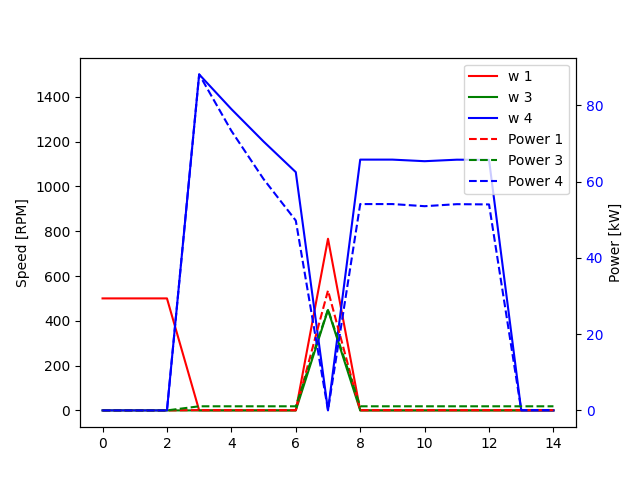

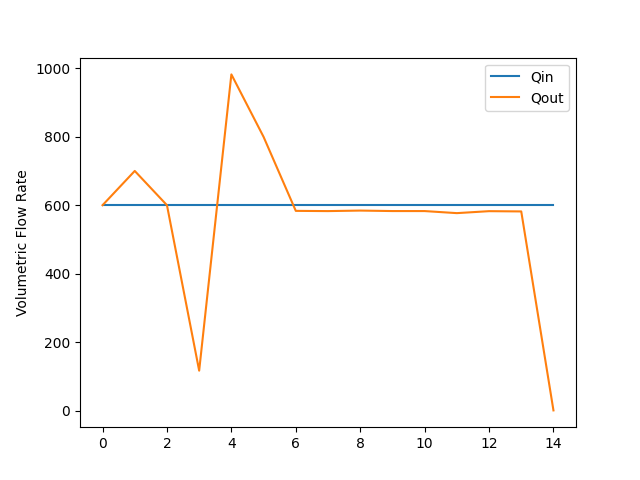

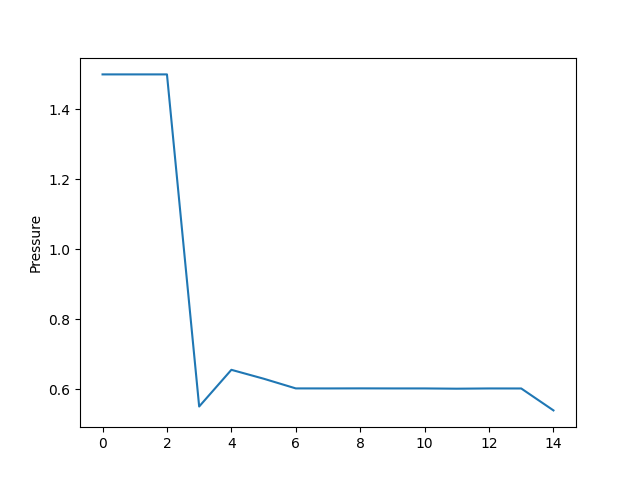

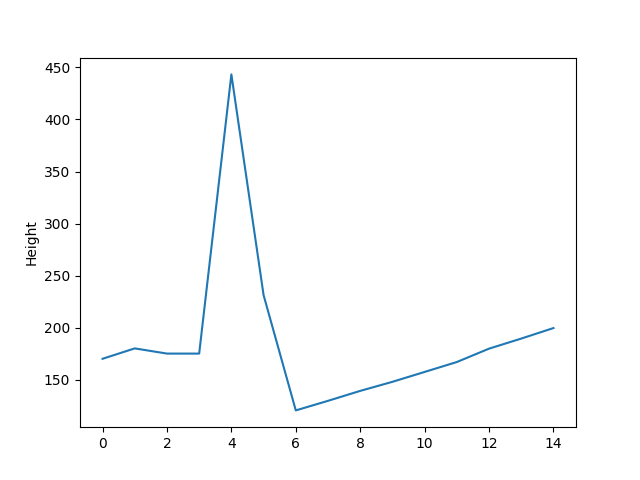

In [22]:
plt.clf()    
ax1 = plt.subplot(1,1,1)
plt.plot(sol.value(w)[0,:]**2,"r",label='w 1')
plt.plot(sol.value(w)[1,:]**2,"g",label='w 3')
plt.plot(sol.value(w)[2,:]**2,"b",label='w 4')
# plt.plot(sol.value(w),"r",label='w 1')
plt.ylabel('Speed [RPM]')
ax12 = ax1.twinx()
ax12.plot(sol.value(E)[0,:],"r--",label='Power 1')
ax12.plot(sol.value(E)[1,:],"g--",label='Power 3')
ax12.plot(sol.value(E)[2,:],"b--",label='Power 4')
ax12.set_ylabel('Power [kW]')
ax12.tick_params(axis ='y', labelcolor = 'blue')
h1, l1 = ax1.get_legend_handles_labels()
h12, l12 = ax12.get_legend_handles_labels()
ax1.legend(h1+h12, l1+l12, loc=1) 
plt.show()

plt.figure()
plt.plot(sol.value(h),label='h')
plt.ylabel("Height")
plt.figure()
plt.plot(sol.value(Qin),label='Qin')
plt.plot(sol.value(Qout**2),label='Qout')
plt.ylabel("Volumetric Flow Rate")
plt.legend()
plt.show()

plt.figure()
plt.plot(sol.value(P),label='P')
plt.ylabel("Pressure")
plt.show()

